In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from triangle import triangulate, plot as tplot, convex_hull, show_data, get_data

from random import choice, sample
import matplotlib.colors as mcolors

import dill
dill.settings['recurse'] = True

from tqdm import tqdm

In [2]:
F = dill.load(open("integrals", "rb"))

In [3]:
t = np.linspace(0, 2*np.pi, 40, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T
seg = np.array([[j, j+1] for j in range(points.shape[0]-1)] + [[points.shape[0] - 1, 0]])

In [4]:
points = np.array([
[0, 0],
[0, 1],
[1, 1],
[1, 0]
])
seg = np.array([
[0, 1],
[1, 2],
[2, 3],
[3, 0]
])

In [5]:
cndt = triangulate({"vertices":points, "segments":seg}, opts="Rpq30a0.01ne")

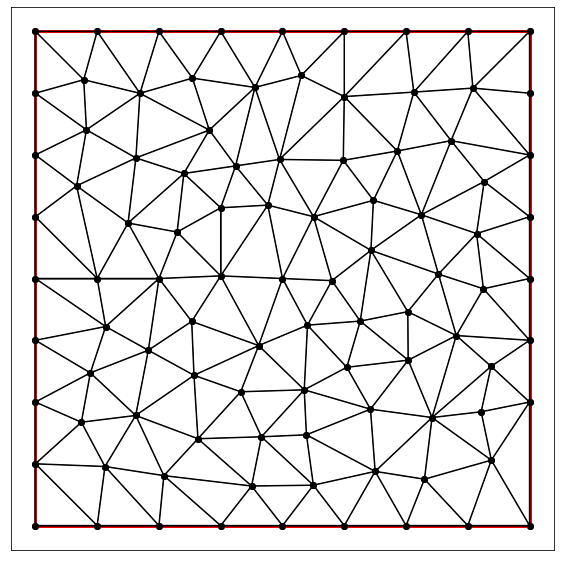

In [6]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.subplot(111, aspect='equal')
tplot(ax, **cndt)
plt.show()

In [7]:
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
triangles_s = points[triangles]
triangles_c = triangles_s.reshape(-1, 2)

In [8]:
is_boundary_point = np.zeros(points.shape[0], dtype=bool)
boundary_normal = np.zeros((points.shape[0], 2))

is_set = np.zeros(points.shape[0], dtype=np.bool_)

In [9]:
for index, element in enumerate(triangles):
    
    if (neighbours[index] == -1).sum() == 2:
        
        is_boundary_point[element] = True
        
    elif (neighbours[index] == -1).sum() == 1:
        
        indices_ = np.where(neighbours[index] != -1)[0]
        is_boundary_point[element[indices_]] = True
        
        origin_point_idx = element[indices_[0]] if is_boundary_point[element[(indices_[0] + 1) % 3]] == True else element[indices_[1]]
        end_point_idx = element[indices_[0]] if origin_point_idx == element[indices_[1]] else element[indices_[1]]
        
        
        fp = points[origin_point_idx]
        sp = points[end_point_idx]
        
        scale = ((sp - fp)**2).sum() ** 0.5
        
        boundary_normal[origin_point_idx][0] =  -(fp[1] - sp[1]) / scale
        boundary_normal[origin_point_idx][1] =  (fp[0] - sp[0]) /scale
        
        is_set[origin_point_idx] = True

        
for index, element in enumerate(triangles):
    
    if (neighbours[index] == -1).sum() == 2:
        
        set_ = np.where(is_set[element] == True)[0][0]
        
        start_1 = (set_ + 1) % 3
        end_1 = (start_1 + 1) % 3
        
        start_2 = end_1
        end_2 = set_
        
        
        boundary_normal[element[start_1]][0] =  (points[element[end_1]][1] - points[element[start_1]][1])*5
        boundary_normal[element[start_1]][1] =  -(points[element[end_1]][0] - points[element[start_1]][0])*5     
                
        boundary_normal[element[start_2]][0] =  (points[element[end_2]][1] - points[element[start_2]][1])*5
        boundary_normal[element[start_2]][1] =  -(points[element[end_2]][0] - points[element[start_2]][0])*5             

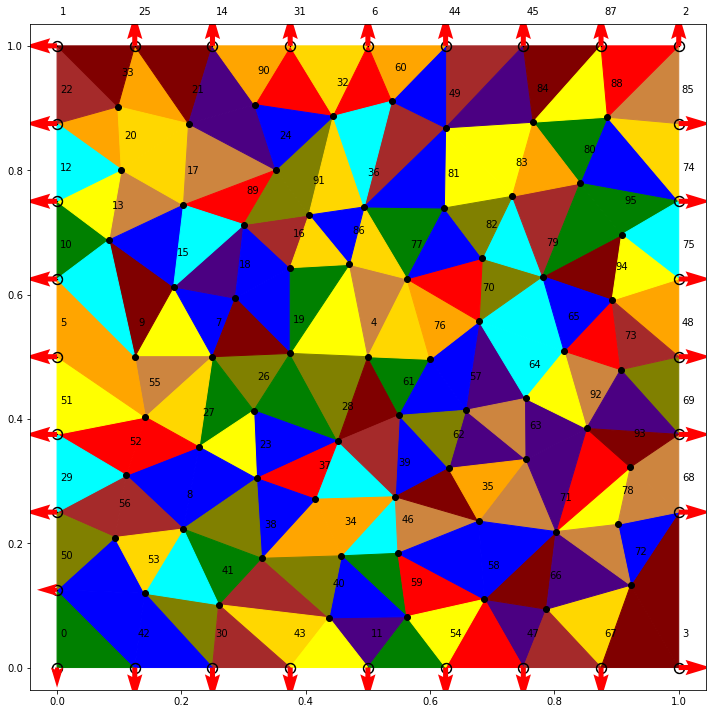

In [10]:
colors = ["blue", "green", "yellow", "red", "cyan", "brown", "blue", "orange", "olive", "gold", "indigo", "peru", "maroon"]
l = len(colors)

%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis("equal")


for index, triangle in enumerate(triangles_s):
    t1 = plt.Polygon(triangle, color=colors[index%l])
    fig.gca().add_patch(t1)
    
    x, y = triangle.mean(axis=0)
#     ax.text(x, y, s=f"{index}", fontsize=10)

for idx, point in enumerate(points):
    ax.text(x=point[0]+0.005, y=point[1]+0.05, s=f"{idx}", fontsize=10, color="black")
    
for idx, point in enumerate(points):
    if is_boundary_point[idx]:
        ax.scatter(point[0], point[1], color="black", lw=10, s=2)
        ax.quiver(point[0], point[1], boundary_normal[idx,0], boundary_normal[idx,1], color=['r','b','g'], scale=21)

    else:
        ax.scatter(point[0], point[1], color="black")
        
fig.tight_layout()
plt.show()

In [11]:
matrix = np.zeros((6 * points.shape[0], 6 * points.shape[0]), dtype=np.float32)
b = np.zeros(6 * points.shape[0])

In [12]:
for idx, element in enumerate(tqdm(triangles)):
        
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]
    
    S2 = (-x1 + x2) * (-y1 + y3) - (-x1 + x3) * (-y1 + y2)
    
    P_1_x = (+y2 - y3) / S2
    P_2_x = (-y1 + y3) / S2
    P_3_x = (+y1 - y2) / S2
    
    P_1_y = (-x2 + x3) / S2
    P_2_y = (+x1 - x3) / S2
    P_3_y = (-x1 + x2) / S2
    
    arg = [P_1_x, P_2_x, P_3_x, P_1_y, P_2_y, P_3_y]
#     delta = (P_1_x * P_2_y) - (P_2_x * P_1_y)
    delta = (x1 - x3) * (y2 - y3) - (y1 - y3) * (x2 - x3)
    
    
    # p_1
    if is_boundary_point[element[0]] == True:
        
        matrix[6 * element[0]+0, 6 * element[0]+0] = 1
        matrix[6 * element[0]+1, 6 * element[0]+1] = 1
        matrix[6 * element[0]+2, 6 * element[0]+2] = 1        
        matrix[6 * element[0]+3, 6 * element[0]+3] = 1        
        matrix[6 * element[0]+4, 6 * element[0]+4] = 1
        matrix[6 * element[0]+5, 6 * element[0]+5] = 1
        
            
        b[6 * element[0]+0] *= 0
        b[6 * element[0]+1] *= 0
        b[6 * element[0]+2] *= 0
        b[6 * element[0]+3] *= 0
        b[6 * element[0]+4] *= 0
        b[6 * element[0]+5] *= 0
    else:
        
        # for f
        matrix[6 * element[0]+0, 6 * element[0]+0] += (F["0_0_xx"](*arg) + 2 * F["0_0_xy"](*arg) + F["0_0_yy"](*arg))*2
        matrix[6 * element[0]+0, 6 * element[0]+1] += (F["0_3_xx"](*arg) + 2 * F["0_3_xy"](*arg) + F["0_3_yy"](*arg))*2
        matrix[6 * element[0]+0, 6 * element[0]+2] += (F["0_6_xx"](*arg) + 2 * F["0_6_xy"](*arg) + F["0_6_yy"](*arg))*2
        matrix[6 * element[0]+0, 6 * element[0]+3] += (F["0_9_xx"](*arg) + 2 * F["0_9_xy"](*arg) + F["0_9_yy"](*arg))*2
        matrix[6 * element[0]+0, 6 * element[0]+4] += (F["0_12_xx"](*arg) + 2 * F["0_12_xy"](*arg) + F["0_12_yy"](*arg))*2
        matrix[6 * element[0]+0, 6 * element[0]+5] += (F["0_15_xx"](*arg) + 2 * F["0_15_xy"](*arg) + F["0_15_yy"](*arg))*2
        
        matrix[6 * element[0]+0, 6 * element[1]+0] += (F["0_1_xx"](*arg) + 2 * F["0_1_xy"](*arg) + F["0_1_yy"](*arg))*2
        matrix[6 * element[0]+0, 6 * element[1]+1] += (F["0_4_xx"](*arg) + 2 * F["0_4_xy"](*arg) + F["0_4_yy"](*arg))*2
        matrix[6 * element[0]+0, 6 * element[1]+2] += (F["0_7_xx"](*arg) + 2 * F["0_7_xy"](*arg) + F["0_7_yy"](*arg))*2
        matrix[6 * element[0]+0, 6 * element[1]+3] += (F["0_10_xx"](*arg) + 2 * F["0_10_xy"](*arg) + F["0_10_yy"](*arg))*2
        matrix[6 * element[0]+0, 6 * element[1]+4] += (F["0_13_xx"](*arg) + 2 * F["0_13_xy"](*arg) + F["0_13_yy"](*arg))*2
        matrix[6 * element[0]+0, 6 * element[1]+5] += (F["0_16_xx"](*arg) + 2 * F["0_16_xy"](*arg) + F["0_16_yy"](*arg))*2
        
        matrix[6 * element[0]+0, 6 * element[2]+0] += (F["0_2_xx"](*arg) + 2 * F["0_2_xy"](*arg) + F["0_2_yy"](*arg))*2
        matrix[6 * element[0]+0, 6 * element[2]+1] += (F["0_5_xx"](*arg) + 2 * F["0_5_xy"](*arg) + F["0_5_yy"](*arg))*2
        matrix[6 * element[0]+0, 6 * element[2]+2] += (F["0_8_xx"](*arg) + 2 * F["0_8_xy"](*arg) + F["0_8_yy"](*arg))*2
        matrix[6 * element[0]+0, 6 * element[2]+3] += (F["0_11_xx"](*arg) + 2 * F["0_11_xy"](*arg) + F["0_11_yy"](*arg))*2
        matrix[6 * element[0]+0, 6 * element[2]+4] += (F["0_14_xx"](*arg) + 2 * F["0_14_xy"](*arg) + F["0_14_yy"](*arg))*2
        matrix[6 * element[0]+0, 6 * element[2]+5] += (F["0_17_xx"](*arg) + 2 * F["0_17_xy"](*arg) + F["0_17_yy"](*arg))*2
        
        
        # for f x
        matrix[6 * element[0]+1, 6 * element[0]+0] += (F["3_0_xx"](*arg) + 2 * F["3_0_xy"](*arg) + F["3_0_yy"](*arg))*2
        matrix[6 * element[0]+1, 6 * element[0]+1] += (F["3_3_xx"](*arg) + 2 * F["3_3_xy"](*arg) + F["3_3_yy"](*arg))*2
        matrix[6 * element[0]+1, 6 * element[0]+2] += (F["3_6_xx"](*arg) + 2 * F["3_6_xy"](*arg) + F["3_6_yy"](*arg))*2
        matrix[6 * element[0]+1, 6 * element[0]+3] += (F["3_9_xx"](*arg) + 2 * F["3_9_xy"](*arg) + F["3_9_yy"](*arg))*2
        matrix[6 * element[0]+1, 6 * element[0]+4] += (F["3_12_xx"](*arg) + 2 * F["3_12_xy"](*arg) + F["3_12_yy"](*arg))*2
        matrix[6 * element[0]+1, 6 * element[0]+5] += (F["3_15_xx"](*arg) + 2 * F["3_15_xy"](*arg) + F["3_15_yy"](*arg))*2
        
        matrix[6 * element[0]+1, 6 * element[1]+0] += (F["3_1_xx"](*arg) + 2 * F["3_1_xy"](*arg) + F["3_1_yy"](*arg))*2
        matrix[6 * element[0]+1, 6 * element[1]+1] += (F["3_4_xx"](*arg) + 2 * F["3_4_xy"](*arg) + F["3_4_yy"](*arg))*2
        matrix[6 * element[0]+1, 6 * element[1]+2] += (F["3_7_xx"](*arg) + 2 * F["3_7_xy"](*arg) + F["3_7_yy"](*arg))*2
        matrix[6 * element[0]+1, 6 * element[1]+3] += (F["3_10_xx"](*arg) + 2 * F["3_10_xy"](*arg) + F["3_10_yy"](*arg))*2
        matrix[6 * element[0]+1, 6 * element[1]+4] += (F["3_13_xx"](*arg) + 2 * F["3_13_xy"](*arg) + F["3_13_yy"](*arg))*2
        matrix[6 * element[0]+1, 6 * element[1]+5] += (F["3_16_xx"](*arg) + 2 * F["3_16_xy"](*arg) + F["3_16_yy"](*arg))*2
        
        matrix[6 * element[0]+1, 6 * element[2]+0] += (F["3_2_xx"](*arg) + 2 * F["3_2_xy"](*arg) + F["3_2_yy"](*arg))*2
        matrix[6 * element[0]+1, 6 * element[2]+1] += (F["3_5_xx"](*arg) + 2 * F["3_5_xy"](*arg) + F["3_5_yy"](*arg))*2
        matrix[6 * element[0]+1, 6 * element[2]+2] += (F["3_8_xx"](*arg) + 2 * F["3_8_xy"](*arg) + F["3_8_yy"](*arg))*2
        matrix[6 * element[0]+1, 6 * element[2]+3] += (F["3_11_xx"](*arg) + 2 * F["3_11_xy"](*arg) + F["3_11_yy"](*arg))*2
        matrix[6 * element[0]+1, 6 * element[2]+4] += (F["3_14_xx"](*arg) + 2 * F["3_14_xy"](*arg) + F["3_14_yy"](*arg))*2
        matrix[6 * element[0]+1, 6 * element[2]+5] += (F["3_17_xx"](*arg) + 2 * F["3_17_xy"](*arg) + F["3_17_yy"](*arg))*2
        
        # for f y
        matrix[6 * element[0]+2, 6 * element[0]+0] += (F["6_0_xx"](*arg) + 2 * F["6_0_xy"](*arg) + F["6_0_yy"](*arg))*2
        matrix[6 * element[0]+2, 6 * element[0]+1] += (F["6_3_xx"](*arg) + 2 * F["6_3_xy"](*arg) + F["6_3_yy"](*arg))*2
        matrix[6 * element[0]+2, 6 * element[0]+2] += (F["6_6_xx"](*arg) + 2 * F["6_6_xy"](*arg) + F["6_6_yy"](*arg))*2
        matrix[6 * element[0]+2, 6 * element[0]+3] += (F["6_9_xx"](*arg) + 2 * F["6_9_xy"](*arg) + F["6_9_yy"](*arg))*2
        matrix[6 * element[0]+2, 6 * element[0]+4] += (F["6_12_xx"](*arg) + 2 * F["6_12_xy"](*arg) + F["6_12_yy"](*arg))*2
        matrix[6 * element[0]+2, 6 * element[0]+5] += (F["6_15_xx"](*arg) + 2 * F["6_15_xy"](*arg) + F["6_15_yy"](*arg))*2
        
        matrix[6 * element[0]+2, 6 * element[1]+0] += (F["6_1_xx"](*arg) + 2 * F["6_1_xy"](*arg) + F["6_1_yy"](*arg))*2
        matrix[6 * element[0]+2, 6 * element[1]+1] += (F["6_4_xx"](*arg) + 2 * F["6_4_xy"](*arg) + F["6_4_yy"](*arg))*2
        matrix[6 * element[0]+2, 6 * element[1]+2] += (F["6_7_xx"](*arg) + 2 * F["6_7_xy"](*arg) + F["6_7_yy"](*arg))*2
        matrix[6 * element[0]+2, 6 * element[1]+3] += (F["6_10_xx"](*arg) + 2 * F["6_10_xy"](*arg) + F["6_10_yy"](*arg))*2
        matrix[6 * element[0]+2, 6 * element[1]+4] += (F["6_13_xx"](*arg) + 2 * F["6_13_xy"](*arg) + F["6_13_yy"](*arg))*2
        matrix[6 * element[0]+2, 6 * element[1]+5] += (F["6_16_xx"](*arg) + 2 * F["6_16_xy"](*arg) + F["6_16_yy"](*arg))*2
        
        matrix[6 * element[0]+2, 6 * element[2]+0] += (F["6_2_xx"](*arg) + 2 * F["6_2_xy"](*arg) + F["6_2_yy"](*arg))*2
        matrix[6 * element[0]+2, 6 * element[2]+1] += (F["6_5_xx"](*arg) + 2 * F["6_5_xy"](*arg) + F["6_5_yy"](*arg))*2
        matrix[6 * element[0]+2, 6 * element[2]+2] += (F["6_8_xx"](*arg) + 2 * F["6_8_xy"](*arg) + F["6_8_yy"](*arg))*2
        matrix[6 * element[0]+2, 6 * element[2]+3] += (F["6_11_xx"](*arg) + 2 * F["6_11_xy"](*arg) + F["6_11_yy"](*arg))*2
        matrix[6 * element[0]+2, 6 * element[2]+4] += (F["6_14_xx"](*arg) + 2 * F["6_14_xy"](*arg) + F["6_14_yy"](*arg))*2
        matrix[6 * element[0]+2, 6 * element[2]+5] += (F["6_17_xx"](*arg) + 2 * F["6_17_xy"](*arg) + F["6_17_yy"](*arg))*2
        
        # for f xy
        matrix[6 * element[0]+3, 6 * element[0]+0] += (F["9_0_xx"](*arg) + 2 * F["9_0_xy"](*arg) + F["9_0_yy"](*arg))*2
        matrix[6 * element[0]+3, 6 * element[0]+1] += (F["9_3_xx"](*arg) + 2 * F["9_3_xy"](*arg) + F["9_3_yy"](*arg))*2
        matrix[6 * element[0]+3, 6 * element[0]+2] += (F["9_6_xx"](*arg) + 2 * F["9_6_xy"](*arg) + F["9_6_yy"](*arg))*2
        matrix[6 * element[0]+3, 6 * element[0]+3] += (F["9_9_xx"](*arg) + 2 * F["9_9_xy"](*arg) + F["9_9_yy"](*arg))*2
        matrix[6 * element[0]+3, 6 * element[0]+4] += (F["9_12_xx"](*arg) + 2 * F["9_12_xy"](*arg) + F["9_12_yy"](*arg))*2
        matrix[6 * element[0]+3, 6 * element[0]+5] += (F["9_15_xx"](*arg) + 2 * F["9_15_xy"](*arg) + F["9_15_yy"](*arg))*2
        
        matrix[6 * element[0]+3, 6 * element[1]+0] += (F["9_1_xx"](*arg) + 2 * F["9_1_xy"](*arg) + F["9_1_yy"](*arg))*2
        matrix[6 * element[0]+3, 6 * element[1]+1] += (F["9_4_xx"](*arg) + 2 * F["9_4_xy"](*arg) + F["9_4_yy"](*arg))*2
        matrix[6 * element[0]+3, 6 * element[1]+2] += (F["9_7_xx"](*arg) + 2 * F["9_7_xy"](*arg) + F["9_7_yy"](*arg))*2
        matrix[6 * element[0]+3, 6 * element[1]+3] += (F["9_10_xx"](*arg) + 2 * F["9_10_xy"](*arg) + F["9_10_yy"](*arg))*2
        matrix[6 * element[0]+3, 6 * element[1]+4] += (F["9_13_xx"](*arg) + 2 * F["9_13_xy"](*arg) + F["9_13_yy"](*arg))*2
        matrix[6 * element[0]+3, 6 * element[1]+5] += (F["9_16_xx"](*arg) + 2 * F["9_16_xy"](*arg) + F["9_16_yy"](*arg))*2
        
        matrix[6 * element[0]+3, 6 * element[2]+0] += (F["9_2_xx"](*arg) + 2 * F["9_2_xy"](*arg) + F["9_2_yy"](*arg))*2
        matrix[6 * element[0]+3, 6 * element[2]+1] += (F["9_5_xx"](*arg) + 2 * F["9_5_xy"](*arg) + F["9_5_yy"](*arg))*2
        matrix[6 * element[0]+3, 6 * element[2]+2] += (F["9_8_xx"](*arg) + 2 * F["9_8_xy"](*arg) + F["9_8_yy"](*arg))*2
        matrix[6 * element[0]+3, 6 * element[2]+3] += (F["9_11_xx"](*arg) + 2 * F["9_11_xy"](*arg) + F["9_11_yy"](*arg))*2
        matrix[6 * element[0]+3, 6 * element[2]+4] += (F["9_14_xx"](*arg) + 2 * F["9_14_xy"](*arg) + F["9_14_yy"](*arg))*2
        matrix[6 * element[0]+3, 6 * element[2]+5] += (F["9_17_xx"](*arg) + 2 * F["9_17_xy"](*arg) + F["9_17_yy"](*arg))*2
        
        # for f xx
        matrix[6 * element[0]+4, 6 * element[0]+0] += (F["12_0_xx"](*arg) + 2 * F["12_0_xy"](*arg) + F["12_0_yy"](*arg))*2
        matrix[6 * element[0]+4, 6 * element[0]+1] += (F["12_3_xx"](*arg) + 2 * F["12_3_xy"](*arg) + F["12_3_yy"](*arg))*2
        matrix[6 * element[0]+4, 6 * element[0]+2] += (F["12_6_xx"](*arg) + 2 * F["12_6_xy"](*arg) + F["12_6_yy"](*arg))*2
        matrix[6 * element[0]+4, 6 * element[0]+3] += (F["12_9_xx"](*arg) + 2 * F["12_9_xy"](*arg) + F["12_9_yy"](*arg))*2
        matrix[6 * element[0]+4, 6 * element[0]+4] += (F["12_12_xx"](*arg) + 2 * F["12_12_xy"](*arg) + F["12_12_yy"](*arg))*2
        matrix[6 * element[0]+4, 6 * element[0]+5] += (F["12_15_xx"](*arg) + 2 * F["12_15_xy"](*arg) + F["12_15_yy"](*arg))*2
        
        matrix[6 * element[0]+4, 6 * element[1]+0] += (F["12_1_xx"](*arg) + 2 * F["12_1_xy"](*arg) + F["12_1_yy"](*arg))*2
        matrix[6 * element[0]+4, 6 * element[1]+1] += (F["12_4_xx"](*arg) + 2 * F["12_4_xy"](*arg) + F["12_4_yy"](*arg))*2
        matrix[6 * element[0]+4, 6 * element[1]+2] += (F["12_7_xx"](*arg) + 2 * F["12_7_xy"](*arg) + F["12_7_yy"](*arg))*2
        matrix[6 * element[0]+4, 6 * element[1]+3] += (F["12_10_xx"](*arg) + 2 * F["12_10_xy"](*arg) + F["12_10_yy"](*arg))*2
        matrix[6 * element[0]+4, 6 * element[1]+4] += (F["12_13_xx"](*arg) + 2 * F["12_13_xy"](*arg) + F["12_13_yy"](*arg))*2
        matrix[6 * element[0]+4, 6 * element[1]+5] += (F["12_16_xx"](*arg) + 2 * F["12_16_xy"](*arg) + F["12_16_yy"](*arg))*2
        
        matrix[6 * element[0]+4, 6 * element[2]+0] += (F["12_2_xx"](*arg) + 2 * F["12_2_xy"](*arg) + F["12_2_yy"](*arg))*2
        matrix[6 * element[0]+4, 6 * element[2]+1] += (F["12_5_xx"](*arg) + 2 * F["12_5_xy"](*arg) + F["12_5_yy"](*arg))*2
        matrix[6 * element[0]+4, 6 * element[2]+2] += (F["12_8_xx"](*arg) + 2 * F["12_8_xy"](*arg) + F["12_8_yy"](*arg))*2
        matrix[6 * element[0]+4, 6 * element[2]+3] += (F["12_11_xx"](*arg) + 2 * F["12_11_xy"](*arg) + F["12_11_yy"](*arg))*2
        matrix[6 * element[0]+4, 6 * element[2]+4] += (F["12_14_xx"](*arg) + 2 * F["12_14_xy"](*arg) + F["12_14_yy"](*arg))*2
        matrix[6 * element[0]+4, 6 * element[2]+5] += (F["12_17_xx"](*arg) + 2 * F["12_17_xy"](*arg) + F["12_17_yy"](*arg))*2
        
        # for f yy
        matrix[6 * element[0]+5, 6 * element[0]+0] += (F["15_0_xx"](*arg) + 2 * F["15_0_xy"](*arg) + F["15_0_yy"](*arg))*2
        matrix[6 * element[0]+5, 6 * element[0]+1] += (F["15_3_xx"](*arg) + 2 * F["15_3_xy"](*arg) + F["15_3_yy"](*arg))*2
        matrix[6 * element[0]+5, 6 * element[0]+2] += (F["15_6_xx"](*arg) + 2 * F["15_6_xy"](*arg) + F["15_6_yy"](*arg))*2
        matrix[6 * element[0]+5, 6 * element[0]+3] += (F["15_9_xx"](*arg) + 2 * F["15_9_xy"](*arg) + F["15_9_yy"](*arg))*2
        matrix[6 * element[0]+5, 6 * element[0]+4] += (F["15_12_xx"](*arg) + 2 * F["15_12_xy"](*arg) + F["15_12_yy"](*arg))*2
        matrix[6 * element[0]+5, 6 * element[0]+5] += (F["15_15_xx"](*arg) + 2 * F["15_15_xy"](*arg) + F["15_15_yy"](*arg))*2
        
        matrix[6 * element[0]+5, 6 * element[1]+0] += (F["15_1_xx"](*arg) + 2 * F["15_1_xy"](*arg) + F["15_1_yy"](*arg))*2
        matrix[6 * element[0]+5, 6 * element[1]+1] += (F["15_4_xx"](*arg) + 2 * F["15_4_xy"](*arg) + F["15_4_yy"](*arg))*2
        matrix[6 * element[0]+5, 6 * element[1]+2] += (F["15_7_xx"](*arg) + 2 * F["15_7_xy"](*arg) + F["15_7_yy"](*arg))*2
        matrix[6 * element[0]+5, 6 * element[1]+3] += (F["15_10_xx"](*arg) + 2 * F["15_10_xy"](*arg) + F["15_10_yy"](*arg))*2
        matrix[6 * element[0]+5, 6 * element[1]+4] += (F["15_13_xx"](*arg) + 2 * F["15_13_xy"](*arg) + F["15_13_yy"](*arg))*2
        matrix[6 * element[0]+5, 6 * element[1]+5] += (F["15_16_xx"](*arg) + 2 * F["15_16_xy"](*arg) + F["15_16_yy"](*arg))*2
        
        matrix[6 * element[0]+5, 6 * element[2]+0] += (F["15_2_xx"](*arg) + 2 * F["15_2_xy"](*arg) + F["15_2_yy"](*arg))*2
        matrix[6 * element[0]+5, 6 * element[2]+1] += (F["15_5_xx"](*arg) + 2 * F["15_5_xy"](*arg) + F["15_5_yy"](*arg))*2
        matrix[6 * element[0]+5, 6 * element[2]+2] += (F["15_8_xx"](*arg) + 2 * F["15_8_xy"](*arg) + F["15_8_yy"](*arg))*2
        matrix[6 * element[0]+5, 6 * element[2]+3] += (F["15_11_xx"](*arg) + 2 * F["15_11_xy"](*arg) + F["15_11_yy"](*arg))*2
        matrix[6 * element[0]+5, 6 * element[2]+4] += (F["15_14_xx"](*arg) + 2 * F["15_14_xy"](*arg) + F["15_14_yy"](*arg))*2
        matrix[6 * element[0]+5, 6 * element[2]+5] += (F["15_17_xx"](*arg) + 2 * F["15_17_xy"](*arg) + F["15_17_yy"](*arg))*2
        
        
        b[6 * element[0]+0] += 2 * 13/84 * delta
        b[6 * element[0]+1] += 2 * -37/840 * delta 
        b[6 * element[0]+2] += 2 * 1/40 * delta
        b[6 * element[0]+3] += 2 * -1/180 * delta
        b[6 * element[0]+4] += 2 * 23/5040 * delta 
        b[6 * element[0]+5] += 2 * 1/720 * delta

        
    # p_2    
    if is_boundary_point[element[1]] == True:
        
        matrix[6 * element[1]+0, 6 * element[1]+0] = 1
        matrix[6 * element[1]+1, 6 * element[1]+1] = 1
        matrix[6 * element[1]+2, 6 * element[1]+2] = 1        
        matrix[6 * element[1]+3, 6 * element[1]+3] = 1        
        matrix[6 * element[1]+4, 6 * element[1]+4] = 1
        matrix[6 * element[1]+5, 6 * element[1]+5] = 1
        
        
        b[6 * element[1]+0] *= 0
        b[6 * element[1]+1] *= 0
        b[6 * element[1]+2] *= 0  
        b[6 * element[1]+3] *= 0 
        b[6 * element[1]+4] *= 0 
        b[6 * element[1]+5] *= 0 
        
    else:
        
        # for f
        matrix[6 * element[1]+0, 6 * element[0]+0] += (F["1_0_xx"](*arg) + 2 * F["1_0_xy"](*arg) + F["1_0_yy"](*arg))*2
        matrix[6 * element[1]+0, 6 * element[0]+1] += (F["1_3_xx"](*arg) + 2 * F["1_3_xy"](*arg) + F["1_3_yy"](*arg))*2
        matrix[6 * element[1]+0, 6 * element[0]+2] += (F["1_6_xx"](*arg) + 2 * F["1_6_xy"](*arg) + F["1_6_yy"](*arg))*2
        matrix[6 * element[1]+0, 6 * element[0]+3] += (F["1_9_xx"](*arg) + 2 * F["1_9_xy"](*arg) + F["1_9_yy"](*arg))*2
        matrix[6 * element[1]+0, 6 * element[0]+4] += (F["1_12_xx"](*arg) + 2 * F["1_12_xy"](*arg) + F["1_12_yy"](*arg))*2
        matrix[6 * element[1]+0, 6 * element[0]+5] += (F["1_15_xx"](*arg) + 2 * F["1_15_xy"](*arg) + F["1_15_yy"](*arg))*2
        
        matrix[6 * element[1]+0, 6 * element[1]+0] += (F["1_1_xx"](*arg) + 2 * F["1_1_xy"](*arg) + F["1_1_yy"](*arg))*2
        matrix[6 * element[1]+0, 6 * element[1]+1] += (F["1_4_xx"](*arg) + 2 * F["1_4_xy"](*arg) + F["1_4_yy"](*arg))*2
        matrix[6 * element[1]+0, 6 * element[1]+2] += (F["1_7_xx"](*arg) + 2 * F["1_7_xy"](*arg) + F["1_7_yy"](*arg))*2
        matrix[6 * element[1]+0, 6 * element[1]+3] += (F["1_10_xx"](*arg) + 2 * F["1_10_xy"](*arg) + F["1_10_yy"](*arg))*2
        matrix[6 * element[1]+0, 6 * element[1]+4] += (F["1_13_xx"](*arg) + 2 * F["1_13_xy"](*arg) + F["1_13_yy"](*arg))*2
        matrix[6 * element[1]+0, 6 * element[1]+5] += (F["1_16_xx"](*arg) + 2 * F["1_16_xy"](*arg) + F["1_16_yy"](*arg))*2
        
        matrix[6 * element[1]+0, 6 * element[2]+0] += (F["1_2_xx"](*arg) + 2 * F["1_2_xy"](*arg) + F["1_2_yy"](*arg))*2
        matrix[6 * element[1]+0, 6 * element[2]+1] += (F["1_5_xx"](*arg) + 2 * F["1_5_xy"](*arg) + F["1_5_yy"](*arg))*2
        matrix[6 * element[1]+0, 6 * element[2]+2] += (F["1_8_xx"](*arg) + 2 * F["1_8_xy"](*arg) + F["1_8_yy"](*arg))*2
        matrix[6 * element[1]+0, 6 * element[2]+3] += (F["1_11_xx"](*arg) + 2 * F["1_11_xy"](*arg) + F["1_11_yy"](*arg))*2
        matrix[6 * element[1]+0, 6 * element[2]+4] += (F["1_14_xx"](*arg) + 2 * F["1_14_xy"](*arg) + F["1_14_yy"](*arg))*2
        matrix[6 * element[1]+0, 6 * element[2]+5] += (F["1_17_xx"](*arg) + 2 * F["1_17_xy"](*arg) + F["1_17_yy"](*arg))*2
       
        # for f x
        matrix[6 * element[1]+1, 6 * element[0]+0] += (F["4_0_xx"](*arg) + 2 * F["4_0_xy"](*arg) + F["4_0_yy"](*arg))*2
        matrix[6 * element[1]+1, 6 * element[0]+1] += (F["4_3_xx"](*arg) + 2 * F["4_3_xy"](*arg) + F["4_3_yy"](*arg))*2
        matrix[6 * element[1]+1, 6 * element[0]+2] += (F["4_6_xx"](*arg) + 2 * F["4_6_xy"](*arg) + F["4_6_yy"](*arg))*2
        matrix[6 * element[1]+1, 6 * element[0]+3] += (F["4_9_xx"](*arg) + 2 * F["4_9_xy"](*arg) + F["4_9_yy"](*arg))*2
        matrix[6 * element[1]+1, 6 * element[0]+4] += (F["4_12_xx"](*arg) + 2 * F["4_12_xy"](*arg) + F["4_12_yy"](*arg))*2
        matrix[6 * element[1]+1, 6 * element[0]+5] += (F["4_15_xx"](*arg) + 2 * F["4_15_xy"](*arg) + F["4_15_yy"](*arg))*2
        
        matrix[6 * element[1]+1, 6 * element[1]+0] += (F["4_1_xx"](*arg) + 2 * F["4_1_xy"](*arg) + F["4_1_yy"](*arg))*2
        matrix[6 * element[1]+1, 6 * element[1]+1] += (F["4_4_xx"](*arg) + 2 * F["4_4_xy"](*arg) + F["4_4_yy"](*arg))*2
        matrix[6 * element[1]+1, 6 * element[1]+2] += (F["4_7_xx"](*arg) + 2 * F["4_7_xy"](*arg) + F["4_7_yy"](*arg))*2
        matrix[6 * element[1]+1, 6 * element[1]+3] += (F["4_10_xx"](*arg) + 2 * F["4_10_xy"](*arg) + F["4_10_yy"](*arg))*2
        matrix[6 * element[1]+1, 6 * element[1]+4] += (F["4_13_xx"](*arg) + 2 * F["4_13_xy"](*arg) + F["4_13_yy"](*arg))*2
        matrix[6 * element[1]+1, 6 * element[1]+5] += (F["4_16_xx"](*arg) + 2 * F["4_16_xy"](*arg) + F["4_16_yy"](*arg))*2
        
        matrix[6 * element[1]+1, 6 * element[2]+0] += (F["4_2_xx"](*arg) + 2 * F["4_2_xy"](*arg) + F["4_2_yy"](*arg))*2
        matrix[6 * element[1]+1, 6 * element[2]+1] += (F["4_5_xx"](*arg) + 2 * F["4_5_xy"](*arg) + F["4_5_yy"](*arg))*2
        matrix[6 * element[1]+1, 6 * element[2]+2] += (F["4_8_xx"](*arg) + 2 * F["4_8_xy"](*arg) + F["4_8_yy"](*arg))*2
        matrix[6 * element[1]+1, 6 * element[2]+3] += (F["4_11_xx"](*arg) + 2 * F["4_11_xy"](*arg) + F["4_11_yy"](*arg))*2
        matrix[6 * element[1]+1, 6 * element[2]+4] += (F["4_14_xx"](*arg) + 2 * F["4_14_xy"](*arg) + F["4_14_yy"](*arg))*2
        matrix[6 * element[1]+1, 6 * element[2]+5] += (F["4_17_xx"](*arg) + 2 * F["4_17_xy"](*arg) + F["4_17_yy"](*arg))*2
        
        # for f y
        matrix[6 * element[1]+2, 6 * element[0]+0] += (F["7_0_xx"](*arg) + 2 * F["7_0_xy"](*arg) + F["7_0_yy"](*arg))*2
        matrix[6 * element[1]+2, 6 * element[0]+1] += (F["7_3_xx"](*arg) + 2 * F["7_3_xy"](*arg) + F["7_3_yy"](*arg))*2
        matrix[6 * element[1]+2, 6 * element[0]+2] += (F["7_6_xx"](*arg) + 2 * F["7_6_xy"](*arg) + F["7_6_yy"](*arg))*2
        matrix[6 * element[1]+2, 6 * element[0]+3] += (F["7_9_xx"](*arg) + 2 * F["7_9_xy"](*arg) + F["7_9_yy"](*arg))*2
        matrix[6 * element[1]+2, 6 * element[0]+4] += (F["7_12_xx"](*arg) + 2 * F["7_12_xy"](*arg) + F["7_12_yy"](*arg))*2
        matrix[6 * element[1]+2, 6 * element[0]+5] += (F["7_15_xx"](*arg) + 2 * F["7_15_xy"](*arg) + F["7_15_yy"](*arg))*2
        
        matrix[6 * element[1]+2, 6 * element[1]+0] += (F["7_1_xx"](*arg) + 2 * F["7_1_xy"](*arg) + F["7_1_yy"](*arg))*2
        matrix[6 * element[1]+2, 6 * element[1]+1] += (F["7_4_xx"](*arg) + 2 * F["7_4_xy"](*arg) + F["7_4_yy"](*arg))*2
        matrix[6 * element[1]+2, 6 * element[1]+2] += (F["7_7_xx"](*arg) + 2 * F["7_7_xy"](*arg) + F["7_7_yy"](*arg))*2
        matrix[6 * element[1]+2, 6 * element[1]+3] += (F["7_10_xx"](*arg) + 2 * F["7_10_xy"](*arg) + F["7_10_yy"](*arg))*2
        matrix[6 * element[1]+2, 6 * element[1]+4] += (F["7_13_xx"](*arg) + 2 * F["7_13_xy"](*arg) + F["7_13_yy"](*arg))*2
        matrix[6 * element[1]+2, 6 * element[1]+5] += (F["7_16_xx"](*arg) + 2 * F["7_16_xy"](*arg) + F["7_16_yy"](*arg))*2
        
        matrix[6 * element[1]+2, 6 * element[2]+0] += (F["7_2_xx"](*arg) + 2 * F["7_2_xy"](*arg) + F["7_2_yy"](*arg))*2
        matrix[6 * element[1]+2, 6 * element[2]+1] += (F["7_5_xx"](*arg) + 2 * F["7_5_xy"](*arg) + F["7_5_yy"](*arg))*2
        matrix[6 * element[1]+2, 6 * element[2]+2] += (F["7_8_xx"](*arg) + 2 * F["7_8_xy"](*arg) + F["7_8_yy"](*arg))*2
        matrix[6 * element[1]+2, 6 * element[2]+3] += (F["7_11_xx"](*arg) + 2 * F["7_11_xy"](*arg) + F["7_11_yy"](*arg))*2
        matrix[6 * element[1]+2, 6 * element[2]+4] += (F["7_14_xx"](*arg) + 2 * F["7_14_xy"](*arg) + F["7_14_yy"](*arg))*2
        matrix[6 * element[1]+2, 6 * element[2]+5] += (F["7_17_xx"](*arg) + 2 * F["7_17_xy"](*arg) + F["7_17_yy"](*arg))*2
     
        # for f xy
        matrix[6 * element[1]+3, 6 * element[0]+0] += (F["10_0_xx"](*arg) + 2 * F["10_0_xy"](*arg) + F["10_0_yy"](*arg))*2
        matrix[6 * element[1]+3, 6 * element[0]+1] += (F["10_3_xx"](*arg) + 2 * F["10_3_xy"](*arg) + F["10_3_yy"](*arg))*2
        matrix[6 * element[1]+3, 6 * element[0]+2] += (F["10_6_xx"](*arg) + 2 * F["10_6_xy"](*arg) + F["10_6_yy"](*arg))*2
        matrix[6 * element[1]+3, 6 * element[0]+3] += (F["10_9_xx"](*arg) + 2 * F["10_9_xy"](*arg) + F["10_9_yy"](*arg))*2
        matrix[6 * element[1]+3, 6 * element[0]+4] += (F["10_12_xx"](*arg) + 2 * F["10_12_xy"](*arg) + F["10_12_yy"](*arg))*2
        matrix[6 * element[1]+3, 6 * element[0]+5] += (F["10_15_xx"](*arg) + 2 * F["10_15_xy"](*arg) + F["10_15_yy"](*arg))*2
        
        matrix[6 * element[1]+3, 6 * element[1]+0] += (F["10_1_xx"](*arg) + 2 * F["10_1_xy"](*arg) + F["10_1_yy"](*arg))*2
        matrix[6 * element[1]+3, 6 * element[1]+1] += (F["10_4_xx"](*arg) + 2 * F["10_4_xy"](*arg) + F["10_4_yy"](*arg))*2
        matrix[6 * element[1]+3, 6 * element[1]+2] += (F["10_7_xx"](*arg) + 2 * F["10_7_xy"](*arg) + F["10_7_yy"](*arg))*2
        matrix[6 * element[1]+3, 6 * element[1]+3] += (F["10_10_xx"](*arg) + 2 * F["10_10_xy"](*arg) + F["10_10_yy"](*arg))*2
        matrix[6 * element[1]+3, 6 * element[1]+4] += (F["10_13_xx"](*arg) + 2 * F["10_13_xy"](*arg) + F["10_13_yy"](*arg))*2
        matrix[6 * element[1]+3, 6 * element[1]+5] += (F["10_16_xx"](*arg) + 2 * F["10_16_xy"](*arg) + F["10_16_yy"](*arg))*2
        
        matrix[6 * element[1]+3, 6 * element[2]+0] += (F["10_2_xx"](*arg) + 2 * F["10_2_xy"](*arg) + F["10_2_yy"](*arg))*2
        matrix[6 * element[1]+3, 6 * element[2]+1] += (F["10_5_xx"](*arg) + 2 * F["10_5_xy"](*arg) + F["10_5_yy"](*arg))*2
        matrix[6 * element[1]+3, 6 * element[2]+2] += (F["10_8_xx"](*arg) + 2 * F["10_8_xy"](*arg) + F["10_8_yy"](*arg))*2
        matrix[6 * element[1]+3, 6 * element[2]+3] += (F["10_11_xx"](*arg) + 2 * F["10_11_xy"](*arg) + F["10_11_yy"](*arg))*2
        matrix[6 * element[1]+3, 6 * element[2]+4] += (F["10_14_xx"](*arg) + 2 * F["10_14_xy"](*arg) + F["10_14_yy"](*arg))*2
        matrix[6 * element[1]+3, 6 * element[2]+5] += (F["10_17_xx"](*arg) + 2 * F["10_17_xy"](*arg) + F["10_17_yy"](*arg))*2
        
        # for f xx
        matrix[6 * element[1]+4, 6 * element[0]+0] += (F["13_0_xx"](*arg) + 2 * F["13_0_xy"](*arg) + F["13_0_yy"](*arg))*2
        matrix[6 * element[1]+4, 6 * element[0]+1] += (F["13_3_xx"](*arg) + 2 * F["13_3_xy"](*arg) + F["13_3_yy"](*arg))*2
        matrix[6 * element[1]+4, 6 * element[0]+2] += (F["13_6_xx"](*arg) + 2 * F["13_6_xy"](*arg) + F["13_6_yy"](*arg))*2
        matrix[6 * element[1]+4, 6 * element[0]+3] += (F["13_9_xx"](*arg) + 2 * F["13_9_xy"](*arg) + F["13_9_yy"](*arg))*2
        matrix[6 * element[1]+4, 6 * element[0]+4] += (F["13_12_xx"](*arg) + 2 * F["13_12_xy"](*arg) + F["13_12_yy"](*arg))*2
        matrix[6 * element[1]+4, 6 * element[0]+5] += (F["13_15_xx"](*arg) + 2 * F["13_15_xy"](*arg) + F["13_15_yy"](*arg))*2
        
        matrix[6 * element[1]+4, 6 * element[1]+0] += (F["13_1_xx"](*arg) + 2 * F["13_1_xy"](*arg) + F["13_1_yy"](*arg))*2
        matrix[6 * element[1]+4, 6 * element[1]+1] += (F["13_4_xx"](*arg) + 2 * F["13_4_xy"](*arg) + F["13_4_yy"](*arg))*2
        matrix[6 * element[1]+4, 6 * element[1]+2] += (F["13_7_xx"](*arg) + 2 * F["13_7_xy"](*arg) + F["13_7_yy"](*arg))*2
        matrix[6 * element[1]+4, 6 * element[1]+3] += (F["13_10_xx"](*arg) + 2 * F["13_10_xy"](*arg) + F["13_10_yy"](*arg))*2
        matrix[6 * element[1]+4, 6 * element[1]+4] += (F["13_13_xx"](*arg) + 2 * F["13_13_xy"](*arg) + F["13_13_yy"](*arg))*2
        matrix[6 * element[1]+4, 6 * element[1]+5] += (F["13_16_xx"](*arg) + 2 * F["13_16_xy"](*arg) + F["13_16_yy"](*arg))*2
        
        matrix[6 * element[1]+4, 6 * element[2]+0] += (F["13_2_xx"](*arg) + 2 * F["13_2_xy"](*arg) + F["13_2_yy"](*arg))*2
        matrix[6 * element[1]+4, 6 * element[2]+1] += (F["13_5_xx"](*arg) + 2 * F["13_5_xy"](*arg) + F["13_5_yy"](*arg))*2
        matrix[6 * element[1]+4, 6 * element[2]+2] += (F["13_8_xx"](*arg) + 2 * F["13_8_xy"](*arg) + F["13_8_yy"](*arg))*2
        matrix[6 * element[1]+4, 6 * element[2]+3] += (F["13_11_xx"](*arg) + 2 * F["13_11_xy"](*arg) + F["13_11_yy"](*arg))*2
        matrix[6 * element[1]+4, 6 * element[2]+4] += (F["13_14_xx"](*arg) + 2 * F["13_14_xy"](*arg) + F["13_14_yy"](*arg))*2
        matrix[6 * element[1]+4, 6 * element[2]+5] += (F["13_17_xx"](*arg) + 2 * F["13_17_xy"](*arg) + F["13_17_yy"](*arg))*2
        
        # for f yy
        matrix[6 * element[1]+5, 6 * element[0]+0] += (F["16_0_xx"](*arg) + 2 * F["16_0_xy"](*arg) + F["16_0_yy"](*arg))*2
        matrix[6 * element[1]+5, 6 * element[0]+1] += (F["16_3_xx"](*arg) + 2 * F["16_3_xy"](*arg) + F["16_3_yy"](*arg))*2
        matrix[6 * element[1]+5, 6 * element[0]+2] += (F["16_6_xx"](*arg) + 2 * F["16_6_xy"](*arg) + F["16_6_yy"](*arg))*2
        matrix[6 * element[1]+5, 6 * element[0]+3] += (F["16_9_xx"](*arg) + 2 * F["16_9_xy"](*arg) + F["16_9_yy"](*arg))*2
        matrix[6 * element[1]+5, 6 * element[0]+4] += (F["16_12_xx"](*arg) + 2 * F["16_12_xy"](*arg) + F["16_12_yy"](*arg))*2
        matrix[6 * element[1]+5, 6 * element[0]+5] += (F["16_15_xx"](*arg) + 2 * F["16_15_xy"](*arg) + F["16_15_yy"](*arg))*2
        
        matrix[6 * element[1]+5, 6 * element[1]+0] += (F["16_1_xx"](*arg) + 2 * F["16_1_xy"](*arg) + F["16_1_yy"](*arg))*2
        matrix[6 * element[1]+5, 6 * element[1]+1] += (F["16_4_xx"](*arg) + 2 * F["16_4_xy"](*arg) + F["16_4_yy"](*arg))*2
        matrix[6 * element[1]+5, 6 * element[1]+2] += (F["16_7_xx"](*arg) + 2 * F["16_7_xy"](*arg) + F["16_7_yy"](*arg))*2
        matrix[6 * element[1]+5, 6 * element[1]+3] += (F["16_10_xx"](*arg) + 2 * F["16_10_xy"](*arg) + F["16_10_yy"](*arg))*2
        matrix[6 * element[1]+5, 6 * element[1]+4] += (F["16_13_xx"](*arg) + 2 * F["16_13_xy"](*arg) + F["16_13_yy"](*arg))*2
        matrix[6 * element[1]+5, 6 * element[1]+5] += (F["16_16_xx"](*arg) + 2 * F["16_16_xy"](*arg) + F["16_16_yy"](*arg))*2
        
        matrix[6 * element[1]+5, 6 * element[2]+0] += (F["16_2_xx"](*arg) + 2 * F["16_2_xy"](*arg) + F["16_2_yy"](*arg))*2
        matrix[6 * element[1]+5, 6 * element[2]+1] += (F["16_5_xx"](*arg) + 2 * F["16_5_xy"](*arg) + F["16_5_yy"](*arg))*2
        matrix[6 * element[1]+5, 6 * element[2]+2] += (F["16_8_xx"](*arg) + 2 * F["16_8_xy"](*arg) + F["16_8_yy"](*arg))*2
        matrix[6 * element[1]+5, 6 * element[2]+3] += (F["16_11_xx"](*arg) + 2 * F["16_11_xy"](*arg) + F["16_11_yy"](*arg))*2
        matrix[6 * element[1]+5, 6 * element[2]+4] += (F["16_14_xx"](*arg) + 2 * F["16_14_xy"](*arg) + F["16_14_yy"](*arg))*2
        matrix[6 * element[1]+5, 6 * element[2]+5] += (F["16_17_xx"](*arg) + 2 * F["16_17_xy"](*arg) + F["16_17_yy"](*arg))*2
        
        
        b[6 * element[1]+0] += 2 * 13/84 * delta
        b[6 * element[1]+1] += 2 * 1/40 * delta
        b[6 * element[1]+2] += 2 * -37/840 * delta
        b[6 * element[1]+3] += 2 * -1/180 * delta
        b[6 * element[1]+4] += 2 * 1/720 * delta
        b[6 * element[1]+5] += 2 * 23/5040 * delta
        
    # p_3    
    if is_boundary_point[element[2]] == True:
        
        matrix[6 * element[2]+0, 6 * element[2]+0] = 1
        matrix[6 * element[2]+1, 6 * element[2]+1] = 1
        matrix[6 * element[2]+2, 6 * element[2]+2] = 1
        matrix[6 * element[2]+3, 6 * element[2]+3] = 1
        matrix[6 * element[2]+4, 6 * element[2]+4] = 1
        matrix[6 * element[2]+5, 6 * element[2]+5] = 1
        

        b[6 * element[2]+0] *= 0
        b[6 * element[2]+1] *= 0
        b[6 * element[2]+2] *= 0
        b[6 * element[2]+3] *= 0
        b[6 * element[2]+4] *= 0
        b[6 * element[2]+5] *= 0
        
    else:
        
        # for f
        matrix[6 * element[2]+0, 6 * element[0]+0] += (F["2_0_xx"](*arg) + 2 * F["2_0_xy"](*arg) + F["2_0_yy"](*arg))*2
        matrix[6 * element[2]+0, 6 * element[0]+1] += (F["2_3_xx"](*arg) + 2 * F["2_3_xy"](*arg) + F["2_3_yy"](*arg))*2
        matrix[6 * element[2]+0, 6 * element[0]+2] += (F["2_6_xx"](*arg) + 2 * F["2_6_xy"](*arg) + F["2_6_yy"](*arg))*2
        matrix[6 * element[2]+0, 6 * element[0]+3] += (F["2_9_xx"](*arg) + 2 * F["2_9_xy"](*arg) + F["2_9_yy"](*arg))*2
        matrix[6 * element[2]+0, 6 * element[0]+4] += (F["2_12_xx"](*arg) + 2 * F["2_12_xy"](*arg) + F["2_12_yy"](*arg))*2
        matrix[6 * element[2]+0, 6 * element[0]+5] += (F["2_15_xx"](*arg) + 2 * F["2_15_xy"](*arg) + F["2_15_yy"](*arg))*2
        
        matrix[6 * element[2]+0, 6 * element[1]+0] += (F["2_1_xx"](*arg) + 2 * F["2_1_xy"](*arg) + F["2_1_yy"](*arg))*2
        matrix[6 * element[2]+0, 6 * element[1]+1] += (F["2_4_xx"](*arg) + 2 * F["2_4_xy"](*arg) + F["2_4_yy"](*arg))*2
        matrix[6 * element[2]+0, 6 * element[1]+2] += (F["2_7_xx"](*arg) + 2 * F["2_7_xy"](*arg) + F["2_7_yy"](*arg))*2
        matrix[6 * element[2]+0, 6 * element[1]+3] += (F["2_10_xx"](*arg) + 2 * F["2_10_xy"](*arg) + F["2_10_yy"](*arg))*2
        matrix[6 * element[2]+0, 6 * element[1]+4] += (F["2_13_xx"](*arg) + 2 * F["2_13_xy"](*arg) + F["2_13_yy"](*arg))*2
        matrix[6 * element[2]+0, 6 * element[1]+5] += (F["2_16_xx"](*arg) + 2 * F["2_16_xy"](*arg) + F["2_16_yy"](*arg))*2
        
        matrix[6 * element[2]+0, 6 * element[2]+0] += (F["2_2_xx"](*arg) + 2 * F["2_2_xy"](*arg) + F["2_2_yy"](*arg))*2
        matrix[6 * element[2]+0, 6 * element[2]+1] += (F["2_5_xx"](*arg) + 2 * F["2_5_xy"](*arg) + F["2_5_yy"](*arg))*2
        matrix[6 * element[2]+0, 6 * element[2]+2] += (F["2_8_xx"](*arg) + 2 * F["2_8_xy"](*arg) + F["2_8_yy"](*arg))*2
        matrix[6 * element[2]+0, 6 * element[2]+3] += (F["2_11_xx"](*arg) + 2 * F["2_11_xy"](*arg) + F["2_11_yy"](*arg))*2
        matrix[6 * element[2]+0, 6 * element[2]+4] += (F["2_14_xx"](*arg) + 2 * F["2_14_xy"](*arg) + F["2_14_yy"](*arg))*2
        matrix[6 * element[2]+0, 6 * element[2]+5] += (F["2_17_xx"](*arg) + 2 * F["2_17_xy"](*arg) + F["2_17_yy"](*arg))*2
       
        # for f x
        matrix[6 * element[2]+1, 6 * element[0]+0] += (F["5_0_xx"](*arg) + 2 * F["5_0_xy"](*arg) + F["5_0_yy"](*arg))*2
        matrix[6 * element[2]+1, 6 * element[0]+1] += (F["5_3_xx"](*arg) + 2 * F["5_3_xy"](*arg) + F["5_3_yy"](*arg))*2
        matrix[6 * element[2]+1, 6 * element[0]+2] += (F["5_6_xx"](*arg) + 2 * F["5_6_xy"](*arg) + F["5_6_yy"](*arg))*2
        matrix[6 * element[2]+1, 6 * element[0]+3] += (F["5_9_xx"](*arg) + 2 * F["5_9_xy"](*arg) + F["5_9_yy"](*arg))*2
        matrix[6 * element[2]+1, 6 * element[0]+4] += (F["5_12_xx"](*arg) + 2 * F["5_12_xy"](*arg) + F["5_12_yy"](*arg))*2
        matrix[6 * element[2]+1, 6 * element[0]+5] += (F["5_15_xx"](*arg) + 2 * F["5_15_xy"](*arg) + F["5_15_yy"](*arg))*2
        
        matrix[6 * element[2]+1, 6 * element[1]+0] += (F["5_1_xx"](*arg) + 2 * F["5_1_xy"](*arg) + F["5_1_yy"](*arg))*2
        matrix[6 * element[2]+1, 6 * element[1]+1] += (F["5_4_xx"](*arg) + 2 * F["5_4_xy"](*arg) + F["5_4_yy"](*arg))*2
        matrix[6 * element[2]+1, 6 * element[1]+2] += (F["5_7_xx"](*arg) + 2 * F["5_7_xy"](*arg) + F["5_7_yy"](*arg))*2
        matrix[6 * element[2]+1, 6 * element[1]+3] += (F["5_10_xx"](*arg) + 2 * F["5_10_xy"](*arg) + F["5_10_yy"](*arg))*2
        matrix[6 * element[2]+1, 6 * element[1]+4] += (F["5_13_xx"](*arg) + 2 * F["5_13_xy"](*arg) + F["5_13_yy"](*arg))*2
        matrix[6 * element[2]+1, 6 * element[1]+5] += (F["5_16_xx"](*arg) + 2 * F["5_16_xy"](*arg) + F["5_16_yy"](*arg))*2
        
        matrix[6 * element[2]+1, 6 * element[2]+0] += (F["5_2_xx"](*arg) + 2 * F["5_2_xy"](*arg) + F["5_2_yy"](*arg))*2
        matrix[6 * element[2]+1, 6 * element[2]+1] += (F["5_5_xx"](*arg) + 2 * F["5_5_xy"](*arg) + F["5_5_yy"](*arg))*2
        matrix[6 * element[2]+1, 6 * element[2]+2] += (F["5_8_xx"](*arg) + 2 * F["5_8_xy"](*arg) + F["5_8_yy"](*arg))*2
        matrix[6 * element[2]+1, 6 * element[2]+3] += (F["5_11_xx"](*arg) + 2 * F["5_11_xy"](*arg) + F["5_11_yy"](*arg))*2
        matrix[6 * element[2]+1, 6 * element[2]+4] += (F["5_14_xx"](*arg) + 2 * F["5_14_xy"](*arg) + F["5_14_yy"](*arg))*2
        matrix[6 * element[2]+1, 6 * element[2]+5] += (F["5_17_xx"](*arg) + 2 * F["5_17_xy"](*arg) + F["5_17_yy"](*arg))*2
        
        # for f y
        matrix[6 * element[2]+2, 6 * element[0]+0] += (F["8_0_xx"](*arg) + 2 * F["8_0_xy"](*arg) + F["8_0_yy"](*arg))*2
        matrix[6 * element[2]+2, 6 * element[0]+1] += (F["8_3_xx"](*arg) + 2 * F["8_3_xy"](*arg) + F["8_3_yy"](*arg))*2
        matrix[6 * element[2]+2, 6 * element[0]+2] += (F["8_6_xx"](*arg) + 2 * F["8_6_xy"](*arg) + F["8_6_yy"](*arg))*2
        matrix[6 * element[2]+2, 6 * element[0]+3] += (F["8_9_xx"](*arg) + 2 * F["8_9_xy"](*arg) + F["8_9_yy"](*arg))*2
        matrix[6 * element[2]+2, 6 * element[0]+4] += (F["8_12_xx"](*arg) + 2 * F["8_12_xy"](*arg) + F["8_12_yy"](*arg))*2
        matrix[6 * element[2]+2, 6 * element[0]+5] += (F["8_15_xx"](*arg) + 2 * F["8_15_xy"](*arg) + F["8_15_yy"](*arg))*2
    
        matrix[6 * element[2]+2, 6 * element[1]+0] += (F["8_1_xx"](*arg) + 2 * F["8_1_xy"](*arg) + F["8_1_yy"](*arg))*2
        matrix[6 * element[2]+2, 6 * element[1]+1] += (F["8_4_xx"](*arg) + 2 * F["8_4_xy"](*arg) + F["8_4_yy"](*arg))*2
        matrix[6 * element[2]+2, 6 * element[1]+2] += (F["8_7_xx"](*arg) + 2 * F["8_7_xy"](*arg) + F["8_7_yy"](*arg))*2
        matrix[6 * element[2]+2, 6 * element[1]+3] += (F["8_10_xx"](*arg) + 2 * F["8_10_xy"](*arg) + F["8_10_yy"](*arg))*2
        matrix[6 * element[2]+2, 6 * element[1]+4] += (F["8_13_xx"](*arg) + 2 * F["8_13_xy"](*arg) + F["8_13_yy"](*arg))*2
        matrix[6 * element[2]+2, 6 * element[1]+5] += (F["8_16_xx"](*arg) + 2 * F["8_16_xy"](*arg) + F["8_16_yy"](*arg))*2
        
        matrix[6 * element[2]+2, 6 * element[2]+0] += (F["8_2_xx"](*arg) + 2 * F["8_2_xy"](*arg) + F["8_2_yy"](*arg))*2
        matrix[6 * element[2]+2, 6 * element[2]+1] += (F["8_5_xx"](*arg) + 2 * F["8_5_xy"](*arg) + F["8_5_yy"](*arg))*2
        matrix[6 * element[2]+2, 6 * element[2]+2] += (F["8_8_xx"](*arg) + 2 * F["8_8_xy"](*arg) + F["8_8_yy"](*arg))*2
        matrix[6 * element[2]+2, 6 * element[2]+3] += (F["8_11_xx"](*arg) + 2 * F["8_11_xy"](*arg) + F["8_11_yy"](*arg))*2
        matrix[6 * element[2]+2, 6 * element[2]+4] += (F["8_14_xx"](*arg) + 2 * F["8_14_xy"](*arg) + F["8_14_yy"](*arg))*2
        matrix[6 * element[2]+2, 6 * element[2]+5] += (F["8_17_xx"](*arg) + 2 * F["8_17_xy"](*arg) + F["8_17_yy"](*arg))*2
     
        # for f xy
        matrix[6 * element[2]+3, 6 * element[0]+0] += (F["11_0_xx"](*arg) + 2 * F["11_0_xy"](*arg) + F["11_0_yy"](*arg))*2
        matrix[6 * element[2]+3, 6 * element[0]+1] += (F["11_3_xx"](*arg) + 2 * F["11_3_xy"](*arg) + F["11_3_yy"](*arg))*2
        matrix[6 * element[2]+3, 6 * element[0]+2] += (F["11_6_xx"](*arg) + 2 * F["11_6_xy"](*arg) + F["11_6_yy"](*arg))*2
        matrix[6 * element[2]+3, 6 * element[0]+3] += (F["11_9_xx"](*arg) + 2 * F["11_9_xy"](*arg) + F["11_9_yy"](*arg))*2
        matrix[6 * element[2]+3, 6 * element[0]+4] += (F["11_12_xx"](*arg) + 2 * F["11_12_xy"](*arg) + F["11_12_yy"](*arg))*2
        matrix[6 * element[2]+3, 6 * element[0]+5] += (F["11_15_xx"](*arg) + 2 * F["11_15_xy"](*arg) + F["11_15_yy"](*arg))*2
        
        matrix[6 * element[2]+3, 6 * element[1]+0] += (F["11_1_xx"](*arg) + 2 * F["11_1_xy"](*arg) + F["11_1_yy"](*arg))*2
        matrix[6 * element[2]+3, 6 * element[1]+1] += (F["11_4_xx"](*arg) + 2 * F["11_4_xy"](*arg) + F["11_4_yy"](*arg))*2
        matrix[6 * element[2]+3, 6 * element[1]+2] += (F["11_7_xx"](*arg) + 2 * F["11_7_xy"](*arg) + F["11_7_yy"](*arg))*2
        matrix[6 * element[2]+3, 6 * element[1]+3] += (F["11_10_xx"](*arg) + 2 * F["11_10_xy"](*arg) + F["11_10_yy"](*arg))*2
        matrix[6 * element[2]+3, 6 * element[1]+4] += (F["11_13_xx"](*arg) + 2 * F["11_13_xy"](*arg) + F["11_13_yy"](*arg))*2
        matrix[6 * element[2]+3, 6 * element[1]+5] += (F["11_16_xx"](*arg) + 2 * F["11_16_xy"](*arg) + F["11_16_yy"](*arg))*2
        
        matrix[6 * element[2]+3, 6 * element[2]+0] += (F["11_2_xx"](*arg) + 2 * F["11_2_xy"](*arg) + F["11_2_yy"](*arg))*2
        matrix[6 * element[2]+3, 6 * element[2]+1] += (F["11_5_xx"](*arg) + 2 * F["11_5_xy"](*arg) + F["11_5_yy"](*arg))*2
        matrix[6 * element[2]+3, 6 * element[2]+2] += (F["11_8_xx"](*arg) + 2 * F["11_8_xy"](*arg) + F["11_8_yy"](*arg))*2
        matrix[6 * element[2]+3, 6 * element[2]+3] += (F["11_11_xx"](*arg) + 2 * F["11_11_xy"](*arg) + F["11_11_yy"](*arg))*2
        matrix[6 * element[2]+3, 6 * element[2]+4] += (F["11_14_xx"](*arg) + 2 * F["11_14_xy"](*arg) + F["11_14_yy"](*arg))*2
        matrix[6 * element[2]+3, 6 * element[2]+5] += (F["11_17_xx"](*arg) + 2 * F["11_17_xy"](*arg) + F["11_17_yy"](*arg))*2
        
        # for f xx
        matrix[6 * element[2]+4, 6 * element[0]+0] += (F["14_0_xx"](*arg) + 2 * F["14_0_xy"](*arg) + F["14_0_yy"](*arg))*2
        matrix[6 * element[2]+4, 6 * element[0]+1] += (F["14_3_xx"](*arg) + 2 * F["14_3_xy"](*arg) + F["14_3_yy"](*arg))*2
        matrix[6 * element[2]+4, 6 * element[0]+2] += (F["14_6_xx"](*arg) + 2 * F["14_6_xy"](*arg) + F["14_6_yy"](*arg))*2
        matrix[6 * element[2]+4, 6 * element[0]+3] += (F["14_9_xx"](*arg) + 2 * F["14_9_xy"](*arg) + F["14_9_yy"](*arg))*2
        matrix[6 * element[2]+4, 6 * element[0]+4] += (F["14_12_xx"](*arg) + 2 * F["14_12_xy"](*arg) + F["14_12_yy"](*arg))*2
        matrix[6 * element[2]+4, 6 * element[0]+5] += (F["14_15_xx"](*arg) + 2 * F["14_15_xy"](*arg) + F["14_15_yy"](*arg))*2
        
        matrix[6 * element[2]+4, 6 * element[1]+0] += (F["14_1_xx"](*arg) + 2 * F["14_1_xy"](*arg) + F["14_1_yy"](*arg))*2
        matrix[6 * element[2]+4, 6 * element[1]+1] += (F["14_4_xx"](*arg) + 2 * F["14_4_xy"](*arg) + F["14_4_yy"](*arg))*2
        matrix[6 * element[2]+4, 6 * element[1]+2] += (F["14_7_xx"](*arg) + 2 * F["14_7_xy"](*arg) + F["14_7_yy"](*arg))*2
        matrix[6 * element[2]+4, 6 * element[1]+3] += (F["14_10_xx"](*arg) + 2 * F["14_10_xy"](*arg) + F["14_10_yy"](*arg))*2
        matrix[6 * element[2]+4, 6 * element[1]+4] += (F["14_13_xx"](*arg) + 2 * F["14_13_xy"](*arg) + F["14_13_yy"](*arg))*2
        matrix[6 * element[2]+4, 6 * element[1]+5] += (F["14_16_xx"](*arg) + 2 * F["14_16_xy"](*arg) + F["14_16_yy"](*arg))*2
        
        matrix[6 * element[2]+4, 6 * element[2]+0] += (F["14_2_xx"](*arg) + 2 * F["14_2_xy"](*arg) + F["14_2_yy"](*arg))*2
        matrix[6 * element[2]+4, 6 * element[2]+1] += (F["14_5_xx"](*arg) + 2 * F["14_5_xy"](*arg) + F["14_5_yy"](*arg))*2
        matrix[6 * element[2]+4, 6 * element[2]+2] += (F["14_8_xx"](*arg) + 2 * F["14_8_xy"](*arg) + F["14_8_yy"](*arg))*2
        matrix[6 * element[2]+4, 6 * element[2]+3] += (F["14_11_xx"](*arg) + 2 * F["14_11_xy"](*arg) + F["14_11_yy"](*arg))*2
        matrix[6 * element[2]+4, 6 * element[2]+4] += (F["14_14_xx"](*arg) + 2 * F["14_14_xy"](*arg) + F["14_14_yy"](*arg))*2
        matrix[6 * element[2]+4, 6 * element[2]+5] += (F["14_17_xx"](*arg) + 2 * F["14_17_xy"](*arg) + F["14_17_yy"](*arg))*2
                
        # for f yy
        matrix[6 * element[2]+5, 6 * element[0]+0] += (F["17_0_xx"](*arg) + 2 * F["17_0_xy"](*arg) + F["17_0_yy"](*arg))*2
        matrix[6 * element[2]+5, 6 * element[0]+1] += (F["17_3_xx"](*arg) + 2 * F["17_3_xy"](*arg) + F["17_3_yy"](*arg))*2
        matrix[6 * element[2]+5, 6 * element[0]+2] += (F["17_6_xx"](*arg) + 2 * F["17_6_xy"](*arg) + F["17_6_yy"](*arg))*2
        matrix[6 * element[2]+5, 6 * element[0]+3] += (F["17_9_xx"](*arg) + 2 * F["17_9_xy"](*arg) + F["17_9_yy"](*arg))*2
        matrix[6 * element[2]+5, 6 * element[0]+4] += (F["17_12_xx"](*arg) + 2 * F["17_12_xy"](*arg) + F["17_12_yy"](*arg))*2
        matrix[6 * element[2]+5, 6 * element[0]+5] += (F["17_15_xx"](*arg) + 2 * F["17_15_xy"](*arg) + F["17_15_yy"](*arg))*2
        
        matrix[6 * element[2]+5, 6 * element[1]+0] += (F["17_1_xx"](*arg) + 2 * F["17_1_xy"](*arg) + F["17_1_yy"](*arg))*2
        matrix[6 * element[2]+5, 6 * element[1]+1] += (F["17_4_xx"](*arg) + 2 * F["17_4_xy"](*arg) + F["17_4_yy"](*arg))*2
        matrix[6 * element[2]+5, 6 * element[1]+2] += (F["17_7_xx"](*arg) + 2 * F["17_7_xy"](*arg) + F["17_7_yy"](*arg))*2
        matrix[6 * element[2]+5, 6 * element[1]+3] += (F["17_10_xx"](*arg) + 2 * F["17_10_xy"](*arg) + F["17_10_yy"](*arg))*2
        matrix[6 * element[2]+5, 6 * element[1]+4] += (F["17_13_xx"](*arg) + 2 * F["17_13_xy"](*arg) + F["17_13_yy"](*arg))*2
        matrix[6 * element[2]+5, 6 * element[1]+5] += (F["17_16_xx"](*arg) + 2 * F["17_16_xy"](*arg) + F["17_16_yy"](*arg))*2
        
        matrix[6 * element[2]+5, 6 * element[2]+0] += (F["17_2_xx"](*arg) + 2 * F["17_2_xy"](*arg) + F["17_2_yy"](*arg))*2
        matrix[6 * element[2]+5, 6 * element[2]+1] += (F["17_5_xx"](*arg) + 2 * F["17_5_xy"](*arg) + F["17_5_yy"](*arg))*2
        matrix[6 * element[2]+5, 6 * element[2]+2] += (F["17_8_xx"](*arg) + 2 * F["17_8_xy"](*arg) + F["17_8_yy"](*arg))*2
        matrix[6 * element[2]+5, 6 * element[2]+3] += (F["17_11_xx"](*arg) + 2 * F["17_11_xy"](*arg) + F["17_11_yy"](*arg))*2
        matrix[6 * element[2]+5, 6 * element[2]+4] += (F["17_14_xx"](*arg) + 2 * F["17_14_xy"](*arg) + F["17_14_yy"](*arg))*2
        matrix[6 * element[2]+5, 6 * element[2]+5] += (F["17_17_xx"](*arg) + 2 * F["17_17_xy"](*arg) + F["17_17_yy"](*arg))*2
        

        b[6 * element[2]+0] += 2 * 4/21 * delta
        b[6 * element[2]+1] += 2 * 13/420 * delta
        b[6 * element[2]+2] += 2 * 13/420 * delta
        b[6 * element[2]+3] += 2 * 1/360 * delta
        b[6 * element[2]+4] += 2 * 1/420 * delta
        b[6 * element[2]+5] += 2 * 1/420 * delta

100%|█████████████████████████████████████████| 159/159 [00:02<00:00, 65.07it/s]


In [13]:
c = np.linalg.solve(matrix, b)

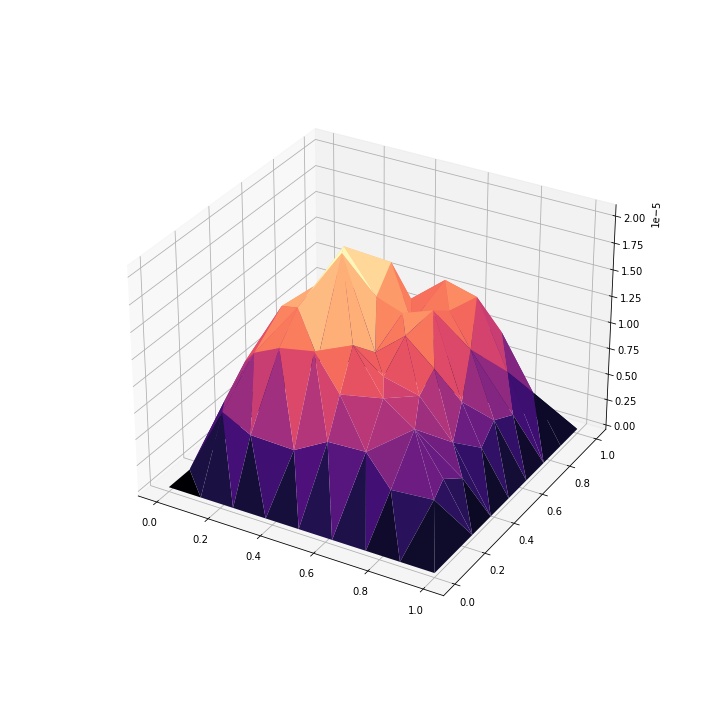

In [15]:
%matplotlib widget
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')


FFF = (1-points[:, 0]**2-points[:, 1]**2)**2/64
ax.plot_trisurf(points[:, 0], points[:, 1], c[0::6], cmap="magma")
# ax.plot_trisurf(points[:, 0], points[:, 1], FFF, color="red")
# ax.plot_trisurf(points[:, 0], points[:, 1], FFF - c[::6])

plt.show()

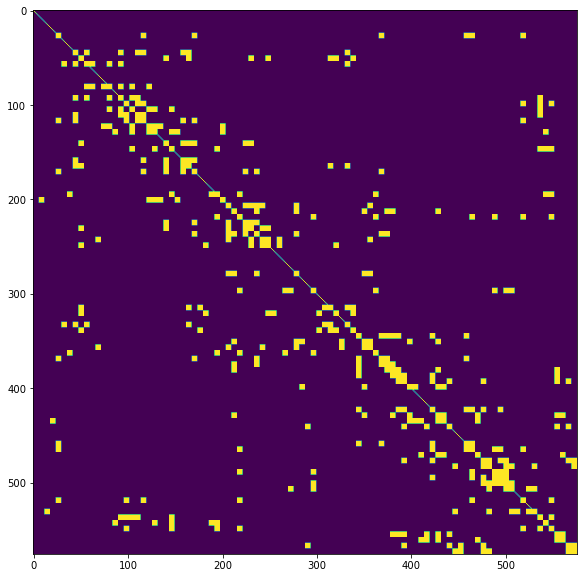

In [16]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(matrix != 0)
plt.show()

In [165]:
1/64

0.015625